## Import

In [1]:
import cudaq
import networkx as nx
from cudaq import spin

from typing import List

import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB
from networkx.algorithms.approximation import maxcut

## Helper functions

### Graph functions

In [2]:
def partition_to_bin(partition):
    """
    This function converts a max cut partition of a graph into a binary number.

    Parameters
    ----------
    partition : tuple
        A tuple containing two sets of nodes that represent the partition of a graph.

    Returns
    -------
    binary_string : str
        A binary number that represents the partition of the graph.
    """
    # Define the subsets
    subset_zero = partition[0]
    subset_one = partition[1]

    # Determine the maximum index to define the size of the binary number
    max_index = max(max(subset_zero), max(subset_one))  # Find the highest index

    # Initialize the binary number list with zeros
    binary_number = [0] * (max_index + 1)

    # Set the positions in the binary number according to the subsets
    for index in subset_one:
        binary_number[index] = 1

    # Since the binary number needs to be expressed as an actual number, convert list to string and then to a binary number
    binary_string = ''.join(str(bit) for bit in binary_number)

    # Print results
    # print("Max cut solution, classical:", binary_string)
    return binary_string


def bin_to_partition(binary_string):
    """
    This function converts a binary number into a max cut partition of a graph.

    Parameters
    ----------
    binary_string : str
        A binary number that represents the partition of the graph.

    Returns
    -------
    partition : tuple
        A tuple containing two sets of nodes that represent the partition of a graph.
    """
    # Convert the binary number to a list of integers
    binary_list = [int(bit) for bit in binary_string]

    # Define the subsets
    subset_zero = set()
    subset_one = set()

    # Set the positions in the subsets according to the binary number
    for index, bit in enumerate(binary_list):
        if bit == 0:
            subset_zero.add(index)
        else:
            subset_one.add(index)

    # Define the partition
    partition = (subset_zero, subset_one)

    # Print results
    # print("Max cut solution, quantum:", partition)
    return partition


def visualize_max_cut(G, partition, title):
    """
    Visualize the graph with the max cut highlighted

    Parameters
    ----------
    G : networkx.Graph
        The input graph
    partition : tuple
        A partition of the nodes of G into two sets
    title : str
        The title of the plot

    Returns
    -------
    None
    """
    # Prepare to plot the graph
    pos = nx.spring_layout(G)  # positions for all nodes using the spring layout

    # Draw 
    nx.draw_networkx_nodes(G, pos, nodelist=partition[0], node_color='red', node_size=500, alpha=0.8) 
    nx.draw_networkx_nodes(G, pos, nodelist=partition[1], node_color='blue', node_size=500, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    # Draw node labels
    nx.draw_networkx_labels(G, pos)

    # Set plot title
    plt.title(title)
    plt.axis('off')  # Turn off the axis
    plt.show()


def max_cut_gurobi(graph):
    model = Model("max_cut")
    model.setParam('OutputFlag', 0)

    # Variables: x[i] is 1 if node i is in one set of the cut, 0 otherwise
    x = model.addVars(graph.nodes(), vtype=GRB.BINARY, name="x")

    # Objective: Maximize the sum of edges between the sets
    model.setObjective(sum(x[i] + x[j] - 2 * x[i] * x[j] for i, j in graph.edges()), GRB.MAXIMIZE)

    # Optimize model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        print('Max-Cut Value:', int(model.objVal))
        group1 = {i for i in graph.nodes() if x[i].X >= 0.5}
        group2 = {i for i in graph.nodes() if x[i].X < 0.5}
        return [group1, group2]
    else:
        print("No optimal solution found.")
        return None

### QAOA functions

In [3]:
def get_hamiltonian(edges):
    """
    Get the Hamiltonian mapping for an arbitrary graph

    Parameters
    ----------
    edges : List[Tuple[int, int]]
        List of edges in the graph
    
    Returns
    -------
    hamiltonian : cudaq.Operator
        Hamiltonian operator
    """
    # avoid 0 term in the Hamiltonian
    hamiltonian = 0.5 * spin.z(edges[0][0]) * spin.z(edges[0][1])
    for u, v in edges[1:]:
        hamiltonian += 0.5 * spin.z(u) * spin.z(v)
    return hamiltonian

    
def cost_function_qaoa(results, edges):
    """
    This function calculates the cost of a max cut solution.

    Parameters
    ----------
    results : list
        A list of results from a quantum algorithm.
    edges : list
        A list of edges in the graph.

    Returns
    -------
    cost : int
        The cost of the max cut solution.
    """
    x_vec = results[0][0]
    cost = 0
    for edge in edges:
        n1, n2 = edge
        print(edge)
        cost += int(x_vec[n1])*(1-int(x_vec[n2])) + int(x_vec[n2])*(1-int(x_vec[n1]))
    return cost

## Pipeline

#########################################################################################
CLASSICAL MAX CUT
Approximate Max Cut value: 22
Partition basic: ({3, 5, 8, 9, 10, 11, 12, 14}, {0, 1, 2, 4, 6, 7, 13, 15})
Binary: 1110101100000101
Start Gurobi Max Cut
Restricted license - for non-production use only - expires 2025-11-24
Max-Cut Value: 22
Partition Gurobi: [{3, 5, 8, 9, 10, 11, 12, 14}, {0, 1, 2, 4, 6, 7, 13, 15}]


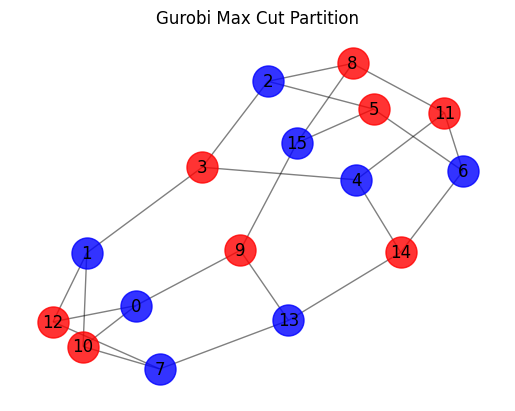

#########################################################################################
QUANTUM MAX CUT
Print circuit of single QAOA layer
      ╭───╮                                                              »
 q0 : ┤ h ├──────────────────────────────────────────────────────────────»
      ├───┤                   ╭───╮╭───────╮╭───╮                        »
 q1 : ┤ h ├───────────────────┤ x ├┤ rz(0) ├┤ x ├────────────────────────»
      ├───┤                   ╰─┬─╯╰───────╯╰─┬─╯╭───╮╭───────╮╭───╮     »
 q2 : ┤ h ├─────────────────────┼─────────────┼──┤ x ├┤ rz(0) ├┤ x ├─────»
      ├───┤                     │             │  ╰─┬─╯╰───────╯╰─┬─╯     »
 q3 : ┤ h ├──●─────────────●────●─────────────●────●─────────────●───────»
      ├───┤╭─┴─╮╭───────╮╭─┴─╮                                           »
 q4 : ┤ h ├┤ x ├┤ rz(0) ├┤ x ├──●─────────────●────●─────────────●───────»
      ├───┤╰───╯╰───────╯╰───╯  │             │    │             │       »
 q5 : ┤ h ├─────────────────────┼─

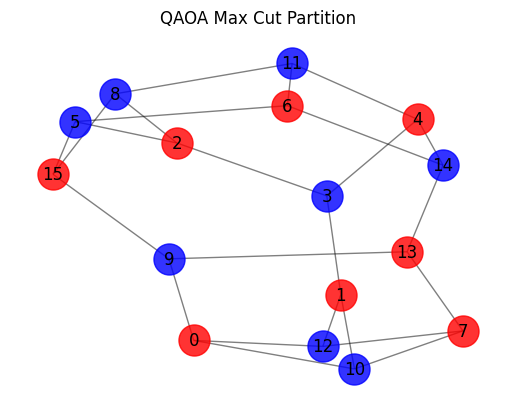

(3, 4)
(3, 1)
(3, 2)
(4, 14)
(4, 11)
(8, 15)
(8, 2)
(8, 11)
(15, 5)
(15, 9)
(2, 5)
(5, 6)
(1, 12)
(1, 10)
(12, 7)
(12, 0)
(13, 14)
(13, 7)
(13, 9)
(14, 6)
(6, 11)
(7, 10)
(10, 0)
(9, 0)
Cost function QAOA: 22


In [4]:
def pipeline(nodes, seed, layer_count, shots_count):
    """
    This function runs the pipeline for the Max Cut problem using QAOA.

    Parameters
    ----------
    nodes : int
        The number of nodes in the graph.
    seed : int
        The seed for the random number generator.
    layer_count : int
        The number of layers in the QAOA ansatz.
    shots_count : int
        The number of shots for the quantum circuit.

    Returns
    -------
    None
    """
    G = nx.random_regular_graph(3, nodes, seed=seed)
    edges = list(G.edges())

    # Use the greedy approximation algorithm for Max Cut
    cut_value, partition_basic = maxcut.one_exchange(G, seed=seed)
    print('#########################################################################################')
    print('CLASSICAL MAX CUT')
    print("Approximate Max Cut value:", cut_value)
    print("Partition basic:", partition_basic)
    print("Binary:", partition_to_bin(partition_basic))
    print("Start Gurobi Max Cut")
    partition_gurobi = max_cut_gurobi(G)
    print("Partition Gurobi:", partition_gurobi)
    visualize_max_cut(G, partition_gurobi, title="Gurobi Max Cut Partition")
    print('#########################################################################################')
    
    print('QUANTUM MAX CUT')
    edges_1 = [edges[i][0] for i in range(len(edges))]
    edges_2 = [edges[i][1] for i in range(len(edges))]
    hamiltonian = get_hamiltonian(edges)

    # Problem parameters
    qubit_count: int = hamiltonian.get_qubit_count()
    layer_count: int = layer_count
    parameter_count: int = 2 * layer_count
    shots_count: int = shots_count

    @cudaq.kernel
    def kernel_qaoa(edges_src: List[int], edges_tgt: List[int], qubit_count: int, layer_count: int, thetas: List[float]):
        """
        QAOA ansatz for Max-Cut
        
        Parameters
        ----------
        edges : List[Tuple[int, int]]
            The edges of the graph.
        qubit_count : int  
            The number of qubits.
        layer_count : int
            The number of layers in the QAOA ansatz.
        thetas : List[float]
            The angles for the QAOA ansatz.
        """
        qvector = cudaq.qvector(qubit_count)

        # Create superposition
        h(qvector)

        # Loop over the layers
        for layer in range(layer_count):
            for i, u in enumerate(edges_src):
                v = edges_tgt[i]
                x.ctrl(qvector[u], qvector[v])
                rz(2.0 * thetas[layer], qvector[v])
                x.ctrl(qvector[u], qvector[v])

            # Mixer unitary
            for qubit in range(qubit_count):
                rx(2.0 * thetas[layer + layer_count], qvector[qubit])

    print("Print circuit of single QAOA layer")
    print(cudaq.draw(kernel_qaoa, edges_1, edges_2, qubit_count, 1, [1,1]))

    # Make it repeatable with fixing random seeds
    cudaq.set_random_seed(13)
    np.random.seed(13)

    # Specify the optimizer and its initial parameters for the angles in the layers
    optimizer = cudaq.optimizers.COBYLA()
    optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0, parameter_count)
    print("Initial QAOA parameters = ", optimizer.initial_parameters)

    def objective(parameters):
        """
        Compute the expected value of the hamiltonian with respect to the kernel.

        Parameters
        ----------
        parameters : List[float]
            The parameters to optimize. Contains the angles for the qaoa ansatz.

        Returns
        -------
        result : float
            The expectation value of the hamiltonian: `<state(params) | H | state(params)>`
        """
        return cudaq.observe(kernel_qaoa, hamiltonian, edges_1, edges_2, qubit_count, layer_count, parameters).expectation()

    optimal_expectation, optimal_parameters = optimizer.optimize(
        dimensions=parameter_count, function=objective)

    # Print the optimized value and its parameters
    print("Optimal expectation value = ", optimal_expectation)
    print("Optimal parameters = ", optimal_parameters)

    # Sample the circuit using the optimized parameters
    counts = cudaq.sample(kernel_qaoa, edges_1, edges_2, qubit_count, layer_count, optimal_parameters, shots_count=1000000)
    results = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    for key, value in results[:10]:
        print(f"{key}: {value}")

    partition_qaoa = bin_to_partition(results[0][0])
    print("Partition QAOA:", partition_qaoa)
    visualize_max_cut(G, partition_qaoa, title="QAOA Max Cut Partition")

    print("Cost function QAOA:", cost_function_qaoa(results, edges))

pipeline(nodes=16, seed=42, layer_count=2, shots_count=1000)